<a href="https://colab.research.google.com/github/devanshupanwar2002/tumor_detection.app/blob/main/Copy_of_Brain_tumor_segmentation_correct_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, filenames in os.walk('/content/drive/MyDrive/machine learning project/datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!jupyter notebook --version

6.4.8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3f124aed-ed41-88b6-a691-46f69420daa4)


In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import TensorBoard,EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'/content/drive/MyDrive/machine learning project/datasets/TRAIN DATASET/yes/'
healthy_dir=r'/content/drive/MyDrive/machine learning project/datasets/TRAIN DATASET/no/'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]

In [ ]:
for i, j in enumerate(dict_list):
  flist = os.listdir(j)
  for f in flist:
        fpath = os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('Tumor')
        else:
          labels.append('Healthy')

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

In [ ]:
#shape of datatset
tumor_df .shape

(3000, 2)

In [ ]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)


In [ ]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(2400, 2)
(600, 2)
(600, 2)
(2400, 2)


In [ ]:

#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe( dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                    )

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Tumor']


In [ ]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

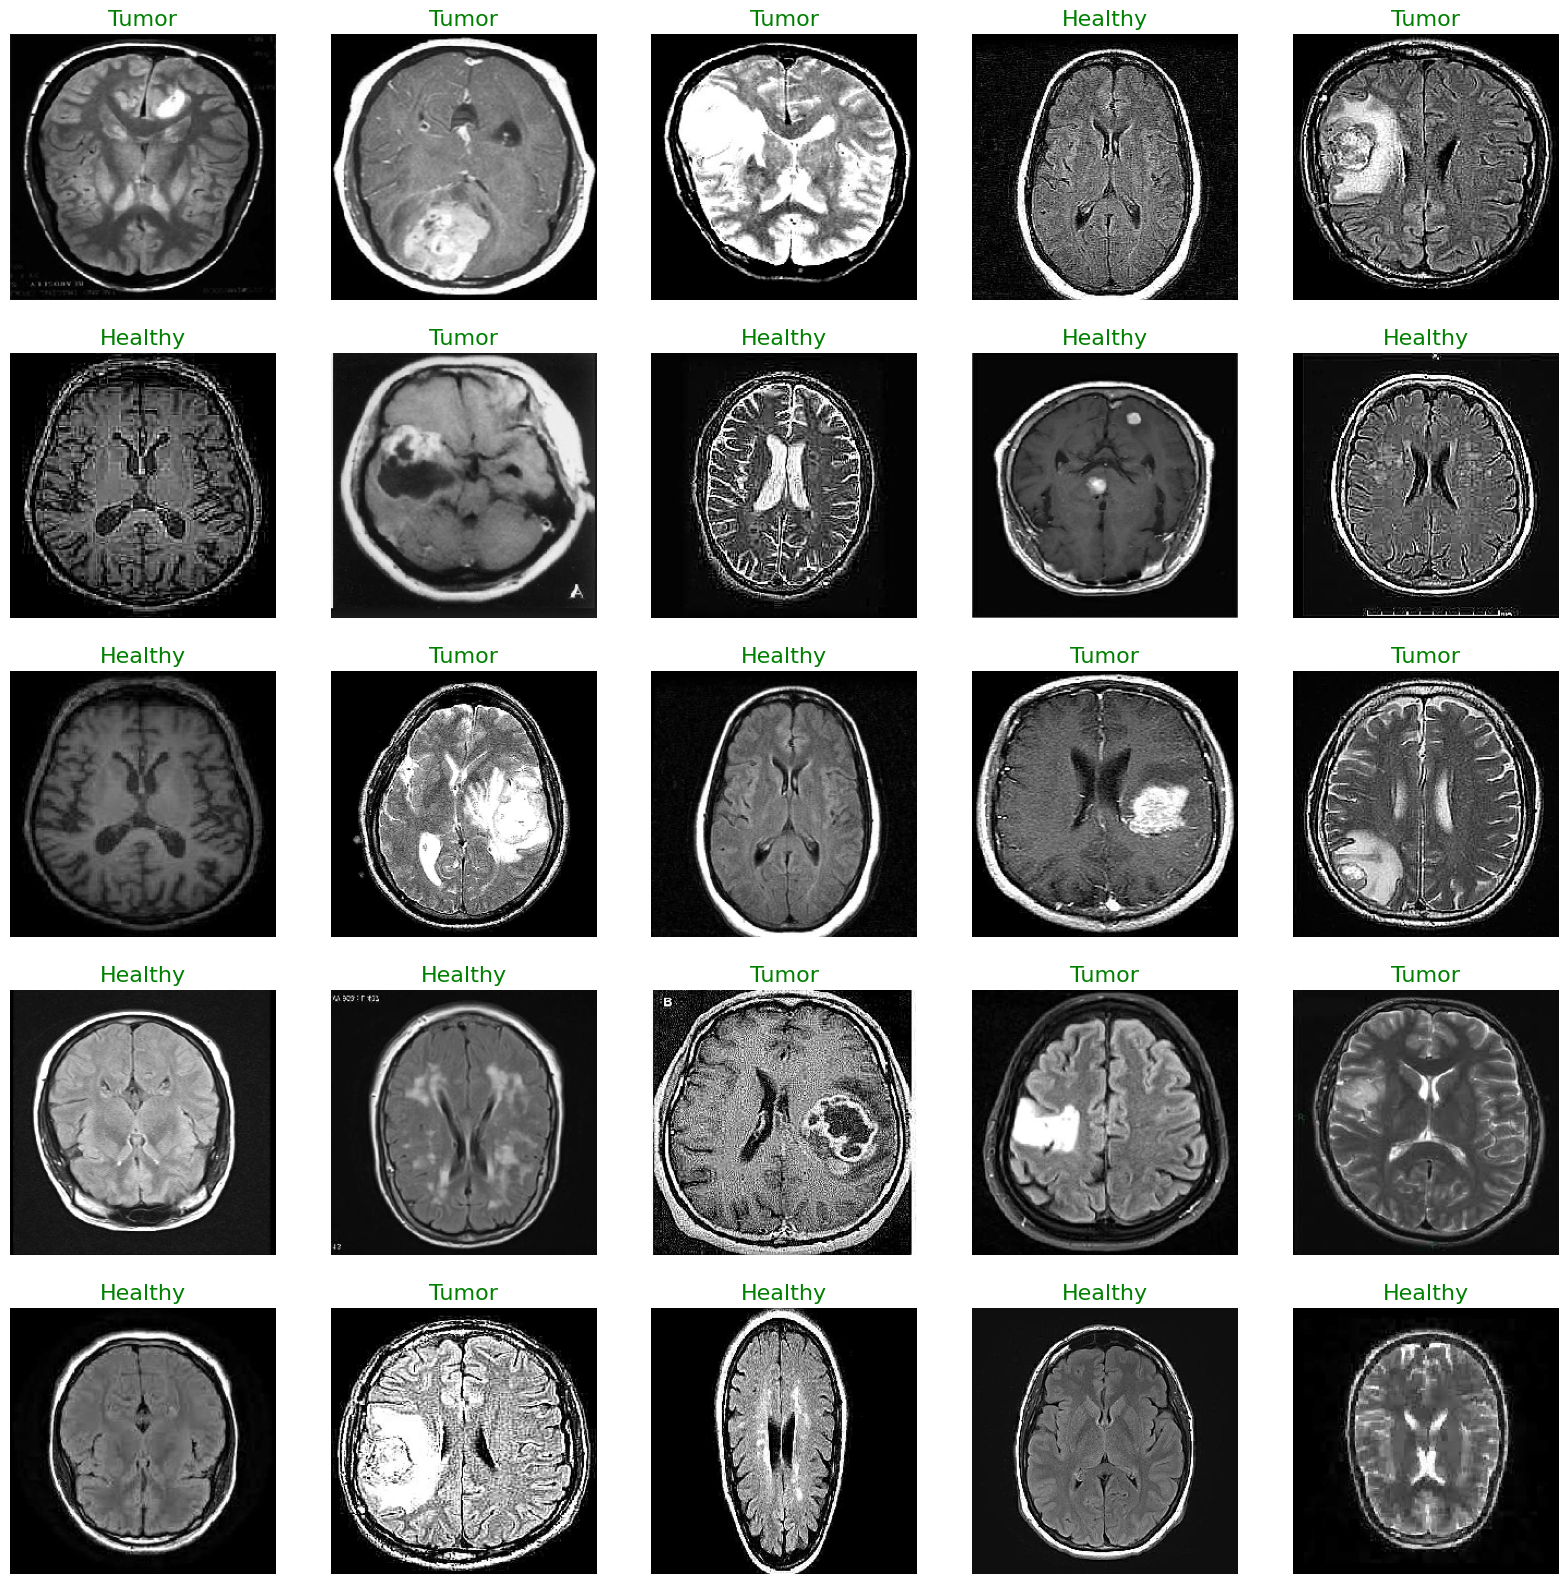

In [ ]:
show_brain_images(train)

In [ ]:
#Defining Sequential Model
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 468512)            0         
                                                                 
 dense (Dense)               (None, 128)               59969664  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

In [ ]:
#model.fit?


In [ ]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

In [ ]:

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)


In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:", accuracy_score(y_test, pred2)*100,"%")

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/braimtumor10epochs.h5')


In [ ]:
!git init

In [ ]:
!git config --global user.name "Ritik_Dutt369"

In [ ]:
!git config --global user.email "ritikdutt89@gmail.com"

In [ ]:
!git commit -m "first commit"

In [ ]:
!git add

In [ ]:
!git add .

In [ ]:
!git branch -M main

In [ ]:
!git status